# Regression
Predict the final goals scored per each team.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import load_model


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile

In [2]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-p_belsiz
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-p_belsiz
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0cc14a8a40d1bddf8f3b04c908c94d69e9d8addce_-cp36-none-any.whl size=114000 sha256=244a08d86038920f1fd589d39d0b29dac8126835527519d9f6c76718ebfa79e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-dbgg446t/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


## Data Preprocessing
    1. Normalization
    2. Data encoding: The goals [0,10] => [-1,1]. If Goal > 10 => 1

In [0]:
df02 = pd.read_csv('https://raw.githubusercontent.com/Khaledjallouli/project/master/data/data_regression_goals/sliding02_goals.csv', sep=',', index_col=0)

In [0]:
df02

,home_team_goal,away_team_goal,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,1,3.50,3.30,2.10,1,3,6,11,16,137,67,117,53,8,2,0,15,6,161,78,72,30
1,2,2,2.50,3.30,2.88,3,1,6,8,16,134,64,151,77,3,3,4,11,18,104,44,87,36
2,1,2,1.91,3.40,4.20,4,2,4,10,15,120,58,124,56,2,2,6,11,15,134,59,100,46
3,2,1,3.25,3.25,2.30,5,2,3,22,12,177,82,74,37,6,3,1,19,8,169,95,113,58
4,3,0,1.20,6.00,19.00,7,2,1,15,8,161,72,74,31,3,2,5,10,17,143,69,134,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,1,5.00,3.80,1.70,4,2,4,10,12,80,43,117,60,2,4,4,10,21,119,58,112,65
7029,4,2,2.00,3.60,3.70,3,2,5,9,21,89,47,92,46,1,4,5,7,21,104,55,63,26
7030,4,1,1.80,3.75,4.50,3,3,4,8,8,122,59,92,50,5,2,3,15,9,84,43,118,56
7031,3,1,1.33,5.25,9.00,2,3,5,12,14,124,62,99,50,3,3,4,11,17,103,53,122,54


In [5]:
byhomegoal = df02.groupby('home_team_goal')
byhomegoal.size().sort_values(ascending=False)

home_team_goal
1     2251
2     1732
0     1589
3      885
4      378
5      132
6       43
7       13
8        7
9        2
10       1
dtype: int64

In [6]:
byawaygoal = df02.groupby('away_team_goal')
byawaygoal.size().sort_values(ascending=False)

away_team_goal
1    2381
0    2362
2    1401
3     613
4     193
5      52
6      23
8       5
7       2
9       1
dtype: int64

### =>The two previous cells show that we can keep 6 classes: [0.5].


In [0]:
def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['home_team_goal','away_team_goal']).values
    y = dataframe[['home_team_goal','away_team_goal']].values
    return X,y

In [0]:
def encode(i):
    switcher = {
        0: -1,
        1: -0.6,
        2: -0.2,
        3: 0.2,
        4: 0.6,
        5: 1,
    }
    # 1 be assigned as default value of passed argument (if goals > 5)
    return switcher.get(i, 1)

def decode(i):
    switcher = {
        -1: 0,
        -0.6: 1,
        -0.2: 2,
        0.2: 3,
        0.6: 4,
        1: 5,
    }
    return switcher.get(i, "ERROR! Use Encode Before!")

In [0]:
def normalize(dataframe):
    column_names_to_not_normalize = ['home_team_goal','away_team_goal']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    x_scaled = preprocessing.normalize(x)
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp
    
    dataframe['home_team_goal'] = dataframe.apply(lambda row: encode(row['home_team_goal']), axis=1)
    dataframe['away_team_goal'] = dataframe.apply(lambda row: encode(row['away_team_goal']), axis=1)
    
    return dataframe

In [10]:
n02 = normalize(df02)

train02, test02 = train_test_split(n02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')


train_X02,train_y02 = get_X_and_y(train02)

test_X02,test_y02 = get_X_and_y(test02)

6329 train examples
704 test examples


In [11]:
n02

,home_team_goal,away_team_goal,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,-0.2,-0.6,0.012482,0.011769,0.007489,0.003566,0.010699,0.021398,0.039230,0.057061,0.488587,0.238944,0.417260,0.189015,0.028531,0.007133,0.000000,0.053495,0.021398,0.574178,0.278173,0.256775,0.106990
1,-0.2,-0.2,0.009236,0.012191,0.010640,0.011083,0.003694,0.022166,0.029555,0.059110,0.495044,0.236439,0.557848,0.284465,0.011083,0.011083,0.014777,0.040638,0.066498,0.384213,0.162552,0.321409,0.132997
2,-0.6,-0.2,0.007188,0.012795,0.015805,0.015053,0.007526,0.015053,0.037632,0.056448,0.451585,0.218266,0.466638,0.210740,0.007526,0.007526,0.022579,0.041395,0.056448,0.504270,0.222029,0.376321,0.173108
3,-0.2,-0.6,0.010289,0.010289,0.007281,0.015829,0.006332,0.009497,0.069647,0.037989,0.560339,0.259592,0.234266,0.117133,0.018995,0.009497,0.003166,0.060149,0.025326,0.535013,0.300747,0.357730,0.183614
4,0.2,-1.0,0.004077,0.020384,0.064551,0.023782,0.006795,0.003397,0.050961,0.027179,0.546982,0.244613,0.251408,0.105320,0.010192,0.006795,0.016987,0.033974,0.057756,0.485829,0.234421,0.455252,0.234421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,-0.2,-0.6,0.020289,0.015420,0.006898,0.016231,0.008116,0.016231,0.040578,0.048694,0.324626,0.174487,0.474766,0.243470,0.008116,0.016231,0.016231,0.040578,0.085214,0.482881,0.235354,0.454477,0.263759
7029,0.6,-0.2,0.009960,0.017929,0.018427,0.014941,0.009960,0.024901,0.044822,0.104584,0.443238,0.234070,0.458179,0.229089,0.004980,0.019921,0.024901,0.034861,0.104584,0.517941,0.273911,0.313753,0.129485
7030,0.6,-0.6,0.007617,0.015870,0.019044,0.012696,0.012696,0.016928,0.033855,0.033855,0.516293,0.249683,0.389336,0.211596,0.021160,0.008464,0.012696,0.063479,0.038087,0.355481,0.181972,0.499366,0.236987
7031,0.2,-0.6,0.005271,0.020806,0.035667,0.007926,0.011889,0.019815,0.047556,0.055483,0.491416,0.245708,0.392341,0.198152,0.011889,0.011889,0.015852,0.043593,0.067372,0.408193,0.210041,0.483490,0.214004


In [12]:
# verif the classes
byhomegoal = df02.groupby('home_team_goal')
byhomegoal.size().sort_values(ascending=False)

home_team_goal
-0.6    2251
-0.2    1732
-1.0    1589
 0.2     885
 0.6     378
 1.0     198
dtype: int64

In [13]:
byawaygoal = df02.groupby('away_team_goal')
byawaygoal.size().sort_values(ascending=False)

away_team_goal
-0.6    2381
-1.0    2362
-0.2    1401
 0.2     613
 0.6     193
 1.0      83
dtype: int64

In [0]:
def round_pred(val):
    if val <=1 and val > 0.67:
        return 1
    elif val <=0.67 and val >0.33:
        return 0.60
    elif val <= 0.33 and val > 0:
        return 0.20
    elif val <= 0 and val > -0.33:
        return -0.20
    elif val<=-0.33 and val> -0.67:
        return -0.60
    else:
        return -1

### Build the model

https://www.tensorflow.org/tutorials/keras/regression
The mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions – i.e. an estimate of how accurate the neural network is in predicting the test data. We can see that with the validation_split set to 0.2, 80% of the training data is used to test the model, while the remaining 20% is used for testing purposes.

In [0]:
def build_model():
  model= tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=30, activation='relu', input_shape=(train_X02.shape[1],)))
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  model.add(tf.keras.layers.Dense(units=10, activation='relu'))
  model.add(tf.keras.layers.Dense(units=2))
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse','accuracy'])
  return model

In [32]:
model = build_model()

EPOCHS = 1000

history = model.fit(
  train_X02, train_y02,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=32,
  callbacks=[tfdocs.modeling.EpochDots()])



Epoch: 0, accuracy:0.7122,  loss:0.2969,  mae:0.4544,  mse:0.2969,  val_accuracy:0.6959,  val_loss:0.2280,  val_mae:0.3809,  val_mse:0.2280,  
....................................................................................................
Epoch: 100, accuracy:0.7158,  loss:0.2005,  mae:0.3572,  mse:0.2005,  val_accuracy:0.6690,  val_loss:0.2059,  val_mae:0.3572,  val_mse:0.2059,  
....................................................................................................
Epoch: 200, accuracy:0.7182,  loss:0.1990,  mae:0.3558,  mse:0.1990,  val_accuracy:0.7125,  val_loss:0.2110,  val_mae:0.3618,  val_mse:0.2110,  
....................................................................................................
Epoch: 300, accuracy:0.7174,  loss:0.1975,  mae:0.3540,  mse:0.1975,  val_accuracy:0.7077,  val_loss:0.2085,  val_mae:0.3574,  val_mse:0.2085,  
....................................................................................................
Epoch: 400, accur

From the output, we can see that the more epochs are run, the lower our MSE and MAE become, indicating improvement in accuracy across each iteration of our model.

**keras is calculating both the training loss and validation loss, i.e. the deviation between the predicted y and actual y as measured by the mean squared error**
Let’s see our respective losses plot on using graph
**Testing loss is decreasing, however Validation loss is still high**

dict_keys(['loss', 'mae', 'mse', 'accuracy', 'val_loss', 'val_mae', 'val_mse', 'val_accuracy'])


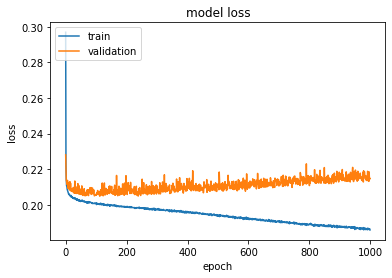

In [33]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
y_train_pred = model.predict(train_X02)
y_test_pred = model.predict(test_X02)

In [35]:
y_train_pred

array([[-0.49964523, -0.48719516],
       [-0.4722548 , -0.6432786 ],
       [-0.48331586, -0.5827433 ],
       ...,
       [-0.43938887, -0.5005152 ],
       [-0.53124684, -0.49210525],
       [-0.14386953, -0.6515794 ]], dtype=float32)

In [36]:
train_y02

array([[-0.2, -0.6],
       [-0.2, -0.2],
       [-0.6, -0.2],
       ...,
       [-0.2,  0.6],
       [-1. ,  0.2],
       [-0.2, -1. ]])

--------------------------------------------------------------
**SECOND MODEL**
------------------------------------------------------------------


In [0]:
def build_model():
  model= tf.keras.models.Sequential()
  #Input Layers
  model.add(tf.keras.layers.Dense(units=30, activation='relu', kernel_initializer='normal', input_shape=(train_X02.shape[1],)))
  #Hidden Layers
  model.add(tf.keras.layers.Dense(units=20, activation='relu', kernel_initializer='normal'))
  model.add(tf.keras.layers.Dense(units=10, activation='relu', kernel_initializer='normal'))
  #model.add(tf.keras.layers.Dense(units=12, activation='relu', kernel_initializer='normal'))
  model.add(tf.keras.layers.Dense(units=2, activation='linear'))
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae', 'mse','accuracy'])
  return model

In [41]:
model = build_model()

EPOCHS = 1000

history = model.fit(
  train_X02, train_y02,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size=32,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.7158,  loss:0.4210,  mae:0.4210,  mse:0.2717,  val_accuracy:0.6959,  val_loss:0.3725,  val_mae:0.3725,  val_mse:0.2338,  
....................................................................................................
Epoch: 100, accuracy:0.6935,  loss:0.3517,  mae:0.3517,  mse:0.2173,  val_accuracy:0.6098,  val_loss:0.3525,  val_mae:0.3525,  val_mse:0.2166,  
....................................................................................................
Epoch: 200, accuracy:0.7095,  loss:0.3472,  mae:0.3472,  mse:0.2125,  val_accuracy:0.7180,  val_loss:0.3458,  val_mae:0.3458,  val_mse:0.2158,  
....................................................................................................
Epoch: 300, accuracy:0.7106,  loss:0.3447,  mae:0.3447,  mse:0.2103,  val_accuracy:0.7243,  val_loss:0.3460,  val_mae:0.3460,  val_mse:0.2126,  
....................................................................................................
Epoch: 400, accur

**Using this model, we can see both Validation Loss and Training loss have reduced exponentially**

dict_keys(['loss', 'mae', 'mse', 'accuracy', 'val_loss', 'val_mae', 'val_mse', 'val_accuracy'])


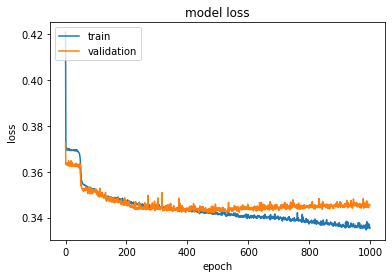

In [42]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**PREDICTIONS**

In [0]:
y_train_pred = model.predict(train_X02)
y_test_pred = model.predict(test_X02)


In [44]:
y_train_pred

array([[-0.5953881 , -0.18985365],
       [-0.5961054 , -0.6028611 ],
       [-0.5899986 , -0.6027007 ],
       ...,
       [-0.59513956, -0.6011291 ],
       [-0.5959617 , -0.18930145],
       [-0.19768421, -0.599358  ]], dtype=float32)

In [45]:
train_y02

array([[-0.2, -0.6],
       [-0.2, -0.2],
       [-0.6, -0.2],
       ...,
       [-0.2,  0.6],
       [-1. ,  0.2],
       [-0.2, -1. ]])

In [0]:
# Train: Round and decode predicted value
ypredhome_train = np.array([round_pred(val) for val in y_train_pred[:,0]])
ypredhome_train = np.array([decode(val) for val in ypredhome_train])

ypredaway_train = np.array([round_pred(val) for val in y_train_pred[:,1]])
ypredaway_train = np.array([decode(val) for val in ypredaway_train])

#decode the goals
yorighome_train = np.array([decode(val) for val in train_y02[:,0]])
yorigaway_train = np.array([decode(val) for val in train_y02[:,1]])

In [0]:
# Test: Round and decode predicted value
ypredhome_test = np.array([round_pred(val) for val in y_test_pred[:,0]])
ypredhome_test = np.array([decode(val) for val in ypredhome_test])

ypredaway_test = np.array([round_pred(val) for val in y_test_pred[:,1]])
ypredaway_test = np.array([decode(val) for val in ypredaway_test])

#decode the goals
yorighome_test = np.array([decode(val) for val in test_y02[:,0]])
yorigaway_test = np.array([decode(val) for val in test_y02[:,1]])

**QUALITY MODEL**

In [0]:
def degree_diff(yoriginal,ypred):
    val = abs(yoriginal - ypred)
    switcher = {
        0: 1, # yoriginal = ypred
        1: 0.8, # diff of 1. Exple original 1 predicted 2 => 0.75
        2: 0.6,
        3: 0.4,
        4: 0.2, # diff of 4. Exple original 0 predicted 4
        5: 0
    }
    return switcher.get(val, 0)

In [49]:
quality_model_home_goals=0

for valorg,valpred in zip(yorighome_train,ypredhome_train):
    quality_model_home_goals += degree_diff(valorg,valpred)
    
quality_model_home_goals = quality_model_home_goals / len(yorighome_train)
print ("Quality model home goals TRAIN", quality_model_home_goals)

Quality model home goals TRAIN 0.8235740243324878


In [50]:
quality_model_away_goals=0

for valorg,valpred in zip(yorigaway_train,ypredaway_train):
    quality_model_away_goals += degree_diff(valorg,valpred)
    
quality_model_away_goals = quality_model_away_goals / len(yorigaway_train)
print ("Quality model away goals TRAIN", quality_model_away_goals)

Quality model away goals TRAIN 0.8419339548112377


In [51]:
#TO DO : Improve the final quality

#final_quality = (quality_model_home_goals**2 + quality_model_away_goals**2)/4
final_quality = (quality_model_home_goals + quality_model_away_goals)/2
final_quality

0.8327539895718628

In [52]:
quality_model_home_goals_test=0

for valorg,valpred in zip(yorighome_test,ypredhome_test):
    quality_model_home_goals_test += degree_diff(valorg,valpred)
    
quality_model_home_goals_test = quality_model_home_goals_test / len(yorighome_test)
print ("Quality model home goals TEST", quality_model_home_goals_test)

Quality model home goals TEST 0.8147727272727301


In [53]:
quality_model_away_goals_test=0

for valorg,valpred in zip(yorigaway_test,ypredaway_test):
    quality_model_away_goals_test += degree_diff(valorg,valpred)
    
quality_model_away_goals_test = quality_model_away_goals_test / len(yorigaway_test)
print ("Quality model away goals TEST", quality_model_away_goals_test)

Quality model away goals TEST 0.8394886363636381


In [54]:
#TO DO : Improve the final quality

#final_quality = (quality_model_home_goals**2 + quality_model_away_goals**2)/4
final_quality_test = (quality_model_home_goals_test + quality_model_away_goals_test)/2
final_quality_test

0.827130681818184